<a href="https://colab.research.google.com/github/tbbcoach/DS-Unit-2-Kaggle-Challenge/blob/main/Copy_of_LS_DS_224_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

In [1]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/main/data/'
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

# Module Project: Classification Metrics

This sprint, the module projects will focus on creating and improving a model for the Tanazania Water Pump dataset. Your goal is to create a model to predict whether a water pump is functional, non-functional, or needs repair.

Dataset source: [DrivenData.org](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/).

## Directions

The tasks for this project are as follows:

- **Task 1:** Use `wrangle` function to import training and test data.
- **Task 2:** Split training data into feature matrix `X` and target vector `y`.
- **Task 3:** Split training data into training and validation sets.
- **Task 4:** Establish the baseline accuracy score for your dataset.
- **Task 5:** Build `model`.
- **Task 6:** Calculate the training and validation accuracy score for your model.
- **Task 7:** Plot the confusion matrix for your model.
- **Task 8:** Print the classification report for your model.
- **Task 9:** Identify likely `'non-functional'` pumps in the test set.
- **Task 10:** Find likely `'non-functional'` pumps serving biggest populations.
- **Task 11 (`stretch goal`):** Plot pump locations from Task 10.

You should limit yourself to the following libraries for this project:

- `category_encoders`
- `matplotlib`
- `pandas`
- `pandas-profiling`
- `plotly`
- `sklearn`


# I. Wrangle Data

In [2]:
import pandas as pd

In [3]:
def wrangle(fm_path, tv_path=None):
    if tv_path:
        df = pd.merge(pd.read_csv(fm_path, 
                                  na_values=[0, -2.000000e-08]),
                      pd.read_csv(tv_path)).set_index('id')
    else:
        df = pd.read_csv(fm_path, 
                         na_values=[0, -2.000000e-08],
                         index_col='id')

    # Drop constant columns
    df.drop(columns=['recorded_by'], inplace=True)

    # Drop HCCCs
    cutoff = 100
    drop_cols = [col for col in df.select_dtypes('object').columns
                 if df[col].nunique() > cutoff]
    df.drop(columns=drop_cols, inplace=True)

    # Drop duplicate columns
    dupe_cols = [col for col in df.head(15).T.duplicated().index
                 if df.head(15).T.duplicated()[col]]
    df.drop(columns=dupe_cols, inplace=True)             

    return df

In [4]:
from google.colab import files
upload = files.upload()

Saving test_features.csv to test_features.csv
Saving train_features.csv to train_features.csv
Saving train_labels.csv to train_labels.csv


**Task 1:** Using the above `wrangle` function to read `train_features.csv` and `train_labels.csv` into the DataFrame `df`, and `test_features.csv` into the DataFrame `X_test`.

In [5]:
df = wrangle('train_features.csv', 'train_labels.csv')
X_test = wrangle('test_features.csv')

In [6]:
df.head()

,amount_tsh,gps_height,longitude,latitude,num_private,basin,region,region_code,district_code,population,public_meeting,scheme_management,permit,construction_year,extraction_type,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,status_group
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,
454.0,50.0,2092.0,35.426020,-4.227446,NaN,Internal,Manyara,21,1.0,160.0,True,Water Board,True,1998.0,gravity,gravity,water board,user-group,pay per bucket,per bucket,soft,good,insufficient,spring,spring,groundwater,communal standpipe,functional
510.0,NaN,NaN,35.510074,-5.724555,NaN,Internal,Dodoma,1,6.0,NaN,True,VWC,True,NaN,india mark ii,handpump,vwc,user-group,never pay,never pay,soft,good,enough,shallow well,shallow well,groundwater,hand pump,functional
14146.0,NaN,NaN,32.499866,-9.081222,NaN,Lake Rukwa,Mbeya,12,6.0,NaN,True,VWC,False,NaN,other,other,vwc,user-group,never pay,never pay,soft,good,enough,shallow well,shallow well,groundwater,other,non functional
47410.0,NaN,NaN,34.060484,-8.830208,NaN,Rufiji,Mbeya,12,7.0,NaN,True,VWC,True,NaN,gravity,gravity,vwc,user-group,pay monthly,monthly,soft,good,insufficient,river,river/lake,surface,communal standpipe,non functional
1288.0,300.0,1023.0,37.032690,-6.040787,NaN,Wami / Ruvu,Morogoro,5,1.0,120.0,True,VWC,True,1997.0,other,other,vwc,user-group,pay when scheme fails,on failure,salty,salty,enough,shallow well,shallow well,groundwater,other,non functional


# II. Split Data

**Task 2:** Split your DataFrame `df` into a feature matrix `X` and the target vector `y`. You want to predict `'status_group'`.

**Note:** You won't need to do a train-test split because you'll use cross-validation instead.

In [7]:
target = 'status_group'

X = df.drop(columns=[target])
y = df[target]

X.shape, y.shape

((47519, 27), (47519,))

**Task 3:** Using a randomized split, divide `X` and `y` into a training set (`X_train`, `y_train`) and a validation set (`X_val`, `y_val`).

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=.2, random_state=42)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((38015, 27), (9504, 27), (38015,), (9504,))

# III. Establish Baseline

**Task 4:** Since this is a **classification** problem, you should establish a baseline accuracy score. Figure out what is the majority class in `y_train` and what percentage of your training observations it represents.

In [9]:
from sklearn.metrics import accuracy_score

y_train.value_counts(normalize=True)
majority_class = y_train.mode()[0]
y_pred = [majority_class] * len(y_train)

baseline_acc = accuracy_score(y_train, y_pred)
print('Baseline Accuracy Score:', baseline_acc)

Baseline Accuracy Score: 0.5425489938182296


# IV. Build Models

**Task 5:** Build and train your `model`. Include the transformers and predictor that you think are most appropriate for this problem.

In [10]:
from sklearn.pipeline import make_pipeline
from category_encoders import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer

model = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy = 'median'),
    RandomForestClassifier(n_estimators= 100, max_depth = 20, n_jobs = -1, random_state=42)
)

model.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['basin', 'region', 'public_meeting',
                                      'scheme_management', 'permit',
                                      'extraction_type',
                                      'extraction_type_class', 'management',
                                      'management_group', 'payment',
                                      'payment_type', 'water_quality',
                                      'quality_group', 'quantity', 'source',
                                      'source_type', 'source_class',
                                      'waterpoint_type'],
                                drop_invariant=False,...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=20, max_features='auto',
                                        m

# V. Check Metrics

**Task 6:** Calculate the training and validation accuracy scores for `model`.

In [11]:
from sklearn.model_selection import cross_val_score

k=10

training_acc = model.score(X_train, y_train)
val_acc = model.score(X_val, y_val)

print('Training Accuracy Score:', training_acc)
print('Validation Accuracy Score:', val_acc)

Training Accuracy Score: 0.9489938182296462
Validation Accuracy Score: 0.7986111111111112


**Task 7:** Plot the confusion matrix for your model, using your validation data.

**Note:** Since there are three classes in your target vector, the dimensions of your matrix will be 3x3.

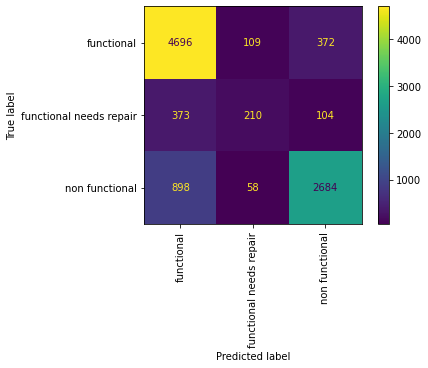

In [12]:
# Plot 3x3 confusion matrix

from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(model, X_val, y_val, values_format = '.0f', xticks_rotation='vertical')

Calculating precision and recall for a multiclass problem is a bit of a mess. Fortunately, we can use `sklearn`'s classification report.

**Task 8:**  Print the classification report for your `model`, using your validation data.

In [13]:
# Print classification report 

from sklearn.metrics import classification_report
y_pred = model.predict(X_val)
print(classification_report(y_val, y_pred))

                         precision    recall  f1-score   support

             functional       0.79      0.91      0.84      5177
functional needs repair       0.56      0.31      0.39       687
         non functional       0.85      0.74      0.79      3640

               accuracy                           0.80      9504
              macro avg       0.73      0.65      0.68      9504
           weighted avg       0.79      0.80      0.79      9504



# VI. Tune Model

Usually, we use this part of the ML workflow to adjust the hyperparameters of the our model to increase performance based on metrics like accuracy. Today, we'll use it to help maximize the impact of our water pump repairs when resources are scarce. What if we only had funds to repair 100 water pumps?

(This activity is based on a [post](https://towardsdatascience.com/maximizing-scarce-maintenance-resources-with-data-8f3491133050) by Lambda alum Michael Brady.)

**Task 9:** Using your model's `predict_proba` method, identify the observations in your **test set** where the model is more than 95% certain that a pump is `'non-functional'`. Put these observations in the DataFrame `X_test_nf`.

In [14]:
y_train = y_train != 'functional'
y_val = y_val != 'functional'
y_train.value_counts(normalize=True)

# threshold = .95
# X_test_nf =  model.predict_proba(X_val)
# X_test_nf

False    0.542549
True     0.457451
Name: status_group, dtype: float64

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


array([0.17834058, 1.        , 0.57594257, ..., 0.81421941, 0.68114932,
       0.76038437])

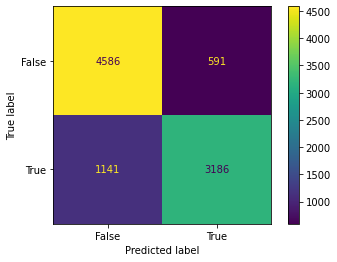

In [15]:
model.fit(X_train, y_train)
y_pred_proba = model.predict_proba(X_val)[:, 1] 

plot_confusion_matrix(model, X_val, y_val, values_format= '.0f')

model.predict_proba(X_val)[:,1]

In [16]:
y_pred_proba.dtype

dtype('float64')

In [17]:
X_test_nf = pd.DataFrame({'y_val': y_val, 'y_pred_proba': y_pred_proba})

X_test_nf = X_test_nf[X_test_nf['y_pred_proba'] > .95]

X_test_nf


,y_val,y_pred_proba
id,,
16772.0,True,1.000000
4125.0,True,0.990000
12693.0,True,0.990002
20316.0,True,0.972706
47371.0,True,0.980000
...,...,...
25535.0,True,0.968493
24396.0,True,0.960817
64589.0,True,0.989286


**Task 10:** Limit `X_test_nf` to the 100 pumps with the largest associated populations.

In [19]:
population = pd.DataFrame({'population': X['population']}).nlargest(100, 'population')

population



X_test_nf, population

(         y_val  y_pred_proba
 id                          
 16772.0   True      1.000000
 4125.0    True      0.990000
 12693.0   True      0.990002
 20316.0   True      0.972706
 47371.0   True      0.980000
 ...        ...           ...
 25535.0   True      0.968493
 24396.0   True      0.960817
 64589.0   True      0.989286
 2254.0    True      0.993855
 48746.0   True      0.979319
 
 [1481 rows x 2 columns],          population
 id                 
 12169.0     30500.0
 49354.0     15300.0
 30750.0     11463.0
 63349.0     10000.0
 33117.0      9865.0
 ...             ...
 38606.0      4800.0
 20618.0      4800.0
 39843.0      4600.0
 30135.0      4550.0
 24551.0      4530.0
 
 [100 rows x 1 columns])

In [42]:
X_test_nf = X_test_nf.merge(X['population'], left_on='id', right_on='id')
X_test_nf.drop(columns=['population_x', 'population_y'], inplace=True)

X_test_nf.nlargest(100, 'population')

,y_val,y_pred_proba,population
id,,,
60369.0,True,0.959091,6000.0
61740.0,True,0.970000,3241.0
56913.0,True,0.980000,2530.0
59972.0,True,0.999615,2300.0
41570.0,True,0.978182,2248.0
...,...,...,...
4948.0,True,0.999828,500.0
9007.0,True,0.981708,500.0
38412.0,True,0.973385,500.0


# VII. Communicate Results

**Task 11 (`stretch goal`):** Create a scatter plot with the location of the 100 pumps in `X_test_nf`.

**Note:** If you want to make this a **`super stretch goal`**, create a Mapbox scatter plot using [Plotly](https://plotly.github.io/plotly.py-docs/generated/plotly.express.scatter_mapbox.html).